# Breast Cancer Classification

Dataset: png images

Source: https://scholar.cu.edu.eg/?q=afahmy/pages/dataset - Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 

Goal: classify with ML techniques malignant and benign tumors.

In [2]:
import pandas as pd
import cv2 
import warnings
from PIL import Image, ImageOps
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn import metrics

## Data Cleaning

In [ ]:
def folder_list():
    folders = []
    benign = '../Dataset_BUSI_with_GT_original/benign/'
    malignant  = '../Dataset_BUSI_with_GT_original/malignant/'
    normal = '../Dataset_BUSI_with_GT_original/normal/'
    folders.append(benign)
    folders.append(malignant)
    folders.append(normal)
return folders

In [ ]:
#Function to bring images to the same size and gray scale
folders = folder_list()
image_size = 310

def resize():
    for folder in folders:
        for item in os.listdir(folder):
            if os.path.isfile(folder+item):
                im = Image.open(folder+item)
                gray_img = ImageOps.grayscale(im)
                f, e = os.path.splitext(folder+item)
                imResize = gray_img.resize((image_size, image_size), Image.ANTIALIAS)
                os.remove(folder+item)
                imResize.save(f + ' resized.png', 'PNG', quality=90)
resize()

In [3]:
#Images dictionary --> {key: image name, value: image}
dic = {}
folders = folder_list()

for folder in folders:
    for filename in os.listdir(folder):
        try:
            img = mpimg.imread(os.path.join(folder, filename))            
            if img is not None:
                dic[filename] = img            
        except:
            print('Cant import ' + filename)
#Check number of images uploaded
print('Images Number: ' + str(len(dic.values())))

## Data exploration

In [5]:
#Pandas DataFrame with two columns: images and corresponding classification value
# 0 = no cancer, 
# 1 = benign cancer, 
# 2 = malignant cancer

df = pd.DataFrame()
images_temp = []
values_temp = []

for key in dic.keys():
    if 'normal' in key:
        images_temp.append(dic[key])
        values_temp.append(0)
    elif 'benign' in key:
        images_temp.append(dic[key])
        values_temp.append(1)
    else: 
        images_temp.append(dic[key])
        values_temp.append(2)
                                 
values = np.asarray(values_temp)

df['Image'] = images_temp
df['Value'] = values

In [6]:
df.shape

(798, 2)

In [7]:
df.isnull().sum()

Image    0
Value    0
dtype: int64

In [9]:
df.head(20)

,Image,Value
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


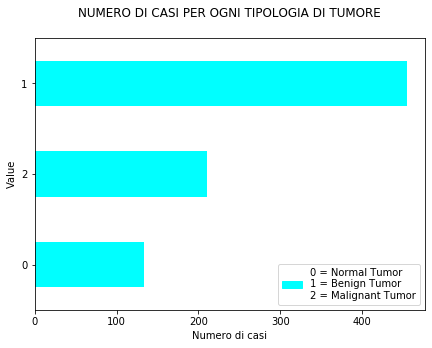

In [8]:
#Number of cases for each type of cancer - Chart
#1 = Benign, 2 = Malignant, 0 = Normal

fig = plt.figure(figsize=(7,5))
df.groupby('Values').Image.count().sort_values().plot.barh(color='aqua', title='Number of cases for each type of cancer\n')
plt.xlabel('Number of cases', fontsize = 10);
label_string = '0 = Normal Tumor' + '\n' + '1 = Benign Tumor' + '\n' + '2 = Malignant Tumor' 
plot_patch = mpatches.Patch(color='aqua', label=label_string)
plt.legend(handles=[plot_patch])

In [9]:
#Training set, test set and validation set

x_train, x_test, y_train, y_test = train_test_split(np.asarray(images_temp), df['Value'], test_size = 0.25, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)

print('Training set -->', 'X:', x_train.shape, 'Y:', y_train.shape)
print('Test set -->', 'X:', x_test.shape, 'Y:', y_test.shape)
print('Validation set -->', 'X:', x_val.shape, 'Y:', y_val.shape)

Training set --> X: (478, 310, 310) Y: (478,)
Test set --> X: (200, 310, 310) Y: (200,)
Validation set --> X: (120, 310, 310) Y: (120,)


In [10]:
# Processing the training, testing and validation sets into a useful form for further analysis
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]
number_of_val = x_val.shape[0]
x_train_flatten = x_train.reshape(number_of_train, x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test.reshape(number_of_test, x_test.shape[1]*x_test.shape[2])
x_val_flatten = x_val.reshape(number_of_val, x_val.shape[1]*x_val.shape[2])
print("Training set:", x_train_flatten.shape)
print("Test set:", x_test_flatten.shape)
print("Validation set:", x_val_flatten.shape)

Training set: (478, 96100)
Test set: (200, 96100)
Validation set: (120, 96100)


## Functions Definition

In [11]:
def plot_learning_curves(model, x, y):
    warnings.filterwarnings("ignore")
    #calcolo learning curves
    train_size, train_error, cv_error = learning_curve(model, x, y, scoring='neg_log_loss', cv=5, 
                                                        train_sizes=[10, 50, 100, 382, 100],
                                                        shuffle=True, random_state=90)

    train_error_mean = -train_error.mean(axis = 1) #- to reverse the negative values of the cost function
    cv_error_mean = -cv_error.mean(axis = 1)

    #plot learning curves
    print()
    plt.title('LEARNING CURVES')
    plt.plot(train_size, train_error_mean, label = 'Training error', color='green')
    plt.plot(train_size, cv_error_mean, label = 'Validation error', color='blue')
    plt.ylabel('Error', fontsize = 15)
    plt.xlabel('Training set size', fontsize = 15)
    plt.legend() 

In [12]:
def model_evaluation (model, predictions, x_train, y_train, x_test, y_test, x_val, y_val):
    #Accuracy for training set, test set and validation set
    print()
    training_score = percentage = "{:.0%}".format(round(model.score(x_train, y_train), 1))
    test_score =  percentage = "{:.0%}".format(round(model.score(x_test, y_test), 1))
    val_score = percentage = "{:.0%}".format(round(model.score(x_val, y_val), 1))
    print("Training set accuracy: ", training_score)
    print("Test set accuracy: ", test_score)
    print("Validation set accuracy: ", val_score)
    print('\n')

    #print("Training set accuracy: ", round(model.score(x_train, y_train), 1))
    #print("Test set accuracy: ", round(model.score(x_test, y_test), 1))
    #print("Validation set accuracy: ", round(model.score(x_val, y_val), 1))

    #Confusion Matrix
    disp = metrics.plot_confusion_matrix(model, x_val, y_val)
    disp.confusion_matrix
    print(metrics.classification_report(y_val, predictions))

In [13]:
#Application of PCA to solve overfitting
def apply_pca(pca, x):
    pca.fit(x)
    x_pca = pca.transform(x)
    x_pca = pd.DataFrame(x_pca)
    return x_pca

In [ ]:
pca = PCA(n_components=2, whiten=True)
x_train_pca = apply_pca(pca, x_train_flatten)
x_test_pca =  apply_pca(pca, x_test_flatten)
x_val_pca = apply_pca(pca, x_val_flatten)

## Classification

- Logistic Regression
- SVM
- Decision Tree
- Neural Network



Training set accuracy:  60%
Test set accuracy:  60%
Validation set accuracy:  50%


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.55      0.83      0.66        65
           2       0.48      0.40      0.43        25

    accuracy                           0.53       120
   macro avg       0.34      0.41      0.36       120
weighted avg       0.39      0.53      0.45       120



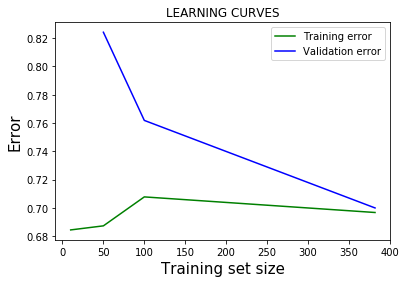

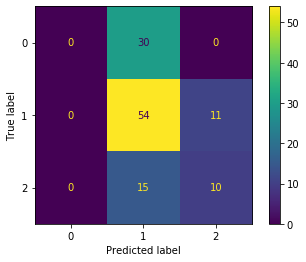

In [14]:
#Logistic Regression (OneVsAll)

lg_model = linear_model.LogisticRegression(C=1, multi_class='ovr', solver='liblinear').fit(x_train_pca, y_train)
lg_predictions = lg_model.predict(x_val_pca)

plot_learning_curves(lg_model, x_train_pca, y_train)
model_evaluation (lg_model, lg_predictions, x_train_pca, y_train, x_test_pca, y_test, x_val_pca, y_val)


Training set accuracy:  60%
Test set accuracy:  60%
Validation set accuracy:  50%


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.55      0.85      0.67        65
           2       0.50      0.40      0.44        25

    accuracy                           0.54       120
   macro avg       0.35      0.42      0.37       120
weighted avg       0.40      0.54      0.45       120



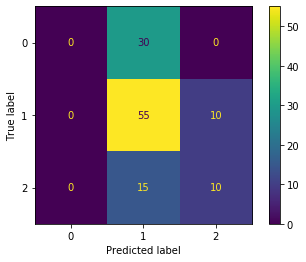

In [15]:
#SVM

svm_model = svm.LinearSVC(C=0.2, dual=False).fit(x_train_pca, y_train)
svm_predictions = svm_model.predict(x_val_pca) 

model_evaluation (svm_model, svm_predictions, x_train_pca, y_train, x_test_pca, y_test, x_val_pca, y_val)



Training set accuracy:  80%
Test set accuracy:  60%
Validation set accuracy:  80%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.79      0.83      0.81        65
           2       0.50      0.44      0.47        25

    accuracy                           0.79       120
   macro avg       0.76      0.76      0.76       120
weighted avg       0.78      0.79      0.79       120



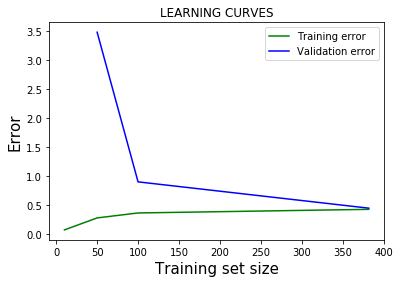

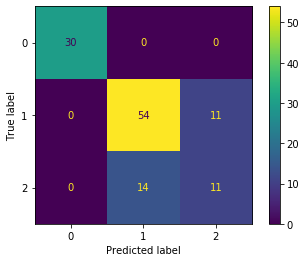

In [16]:
#Decision Tree

dt_model = DecisionTreeClassifier(max_depth = 3).fit(x_train_pca, y_train) 
dt_predictions = dt_model.predict(x_val_pca) 

plot_learning_curves(dt_model, x_train_pca, y_train)
model_evaluation (dt_model, dt_predictions, x_train_pca, y_train, x_test_pca, y_test, x_val_pca, y_val)



Training set accuracy:  80%
Test set accuracy:  70%
Validation set accuracy:  80%


              precision    recall  f1-score   support

           0       0.88      1.00      0.94        30
           1       0.78      0.83      0.81        65
           2       0.59      0.40      0.48        25

    accuracy                           0.78       120
   macro avg       0.75      0.74      0.74       120
weighted avg       0.77      0.78      0.77       120



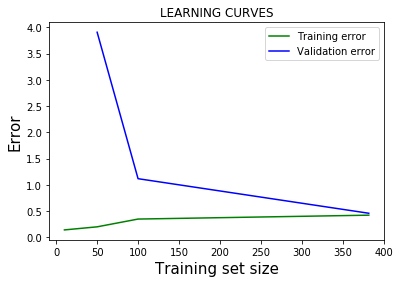

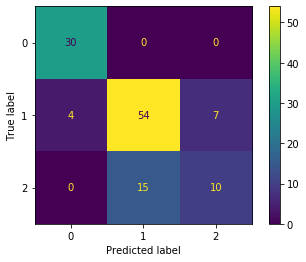

In [17]:
#Neural Networks with OneVsAll

nn_model = OneVsRestClassifier(MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 5), random_state=1, solver='lbfgs'))
nn_model.fit(np.array(x_train_pca), y_train)
nn_predictions = nn_model.predict(x_val_pca)

plot_learning_curves(nn_model, x_train_pca, y_train)
model_evaluation (nn_model, nn_predictions, x_train_pca, y_train, x_test_pca, y_test, x_val_pca, y_val)

In [18]:
#Comparison of the various models tested with a table showing scores for the data of 
#training, testing and validation

from tabulate import tabulate
models = [lg_model, svm_model, dt_model, nn_model]
results = []
for model in models:
    model_name = model.__class__.__name__
    training_score = round(model.score(x_train_pca, y_train), 1)
    test_score = round(model.score(x_test_pca, y_test), 1)
    validation_score = round(model.score(x_val_pca, y_val), 1)
    results.append((model_name, training_score, test_score, validation_score))

print()
print(tabulate(results, headers= ['Modello', 'Training score', 'Test Score', 'Validation Score']))


Modello                   Training score    Test Score    Validation Score
----------------------  ----------------  ------------  ------------------
LogisticRegression                   0.6           0.6                 0.5
LinearSVC                            0.6           0.6                 0.5
DecisionTreeClassifier               0.8           0.6                 0.8
OneVsRestClassifier                  0.8           0.7                 0.8


# Conclusions

Logistic regression and SVM with linear kernel were the first algorithms selected because they are simple and work similarly for problems with a similar number of features and training data as the problem under consideration.
Given the obvious problem of overfitting, after using various techniques, we proceeded by testing other models such as Decision Trees and Neural Networks without obtaining better results, however, in fact the results worsen significantly by increasing even slightly the number of hidden layers or trying to work on the regularization parameter. In general, the various models used fail to make satisfactory predictions, all of them suffering from overfitting.
Various techniques were applied to improve the models: using the training set division, validation set, test set, increasing the regularization parameter or decreasing the C parameter, and using fewer features. 
It was precisely the latter that turned out to be the problem, in fact after the application of the PCA technique to reduce the number of features per pixel, Decision Trees and Neural Networks turned out to be the best models with excellent accuracy as can be seen from the table above.
The model that allows us to obtain the absolute best results is the one obtained from Neural Networks that with two hidden layers of 5 nodes each allows us to reach an accuracy ranging between 70% and 80%.